# AIML CA1
## Classification

Name: Glenn Wu
Adm. No: 2214395
Class: DAAA/FT/2A/01

* How is your prediction task defined? And what is the meaning of the
output variable? 

The prediction task is defined as a binary classification problem. The model will be provided data about a customer and whether they defaulted to train on. Then, the model will use new and unseen customer information to predict whether that user will default or not. <br> The output of the model are either 0 or 1. 0 meaning that the user does not default and 1 meaning that the user does default.
* How do you represent your data as features?


For columns with categorical/discrete values, I use either One Hot Encoding or Ordinal Encoding depending on whether they have any kind of order. One Hot Encoding converts a single column to multiple columns corresponding to each possible value. Ordinal Encoding assigns a number to each value, in order of their "rank".
* Did you process the features in any way?

For columns with numerical/continuous values, I first analyse the distribution of the data, since some models assume that the data has a normal distribution such as Logistic Regression and Gaussian Naive Bayes so I use the 'Yeo-Johnson' transformation on columns with skewed data to unskew them and produce a more normal distribution.
* How did you select which learning algorithms to use?


* Did you try to tune the hyperparameters of the learning algorithm, and in
that case how?
* How do you evaluate the quality of your system?
* How well does your system compare to a dummy baseline?
* Can you say anything about the errors that the system makes? For a
classification task, you may consider a confusion matrix.
* Is it possible to say something about which features the model considers
important? (Whether this is possible depends on the type of classifier
you are using)

False Negatives are more costly than False Positives. When the bank predicts that someone will default, they can decrease their credit limit such that they lose less money in the event that the customer defaults. When the bank predicts that someone will not default, they will either let their credit limit remain the same or increase. 

1. Collecting Data
2. Preparing Data
3. Choosing a Model
4. Training the Model
5. Evaluating the Model
6. Parameter Tuning
7. Predict.

Feature Engineering:
Imputation: Use Average

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random
import copy
import time
import warnings
from tqdm.notebook import tqdm

#todo:
#write custom cv function to random oversample after train validate split
#sga convergence

In [2]:
import sklearn

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# Models
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier

# IMBLEARN
# from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

In [3]:
df = pd.read_csv('credit_dataset.csv', dtype={
    "Credit Limit": int,
    "Gender": "category",
    "Education": "category",
    "Marriage Status": "category",
    "Age": int,
    "Bill_Amount1": int,
    "Bill_Amount2": int,
    "Bill_Amount3": int,
    "Pay_Amount1": int,
    "Pay_Amount2": int,
    "Pay_Amount3": int,
    "Default payment next month": int
}) #loading data
eda_df = df.copy()

(rows_len, cols_len) = eda_df.shape
print(f"Number of Columns: {cols_len}")
print(f"Number of Rows: {rows_len}")
eda_df.head()

Number of Columns: 13
Number of Rows: 1600


,Customer ID,Credit Limit,Gender,Education,Marriage Status,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Default payment next month
0,1,20000,female,univeresity,married,24,3913,3102,689,0,689,0,1
1,2,120000,female,univeresity,single,26,2682,1725,2682,0,1000,1000,1
2,3,90000,female,univeresity,single,34,29239,14027,13559,1518,1500,1000,0
3,4,50000,female,univeresity,married,37,46990,48233,49291,2000,2019,1200,0
4,5,50000,male,univeresity,married,57,8617,5670,35835,2000,36681,10000,0


Performing some initial data cleansing:
* Correct the misspelling of "university"
* Drop the ID column since it is independent and unrelated to the samples.

# Exploratory Data Analysis

We will begin by conducting an exploratory data analysis of the data, to gain a better understanding of the characteristics of the dataset.

The dataset is about Credit Defaults. There are 1600 rows and 13 columns.<br>
**Customer ID**: Unique customer identifier ranging from 1 to 1600<br>
**Credit Limit**: The  credit limit for the customer<br>
**Gender**: Customer gender<br>
**Education**: Customer education level<br>
**Marriage Status**: Customer marital status<br>
**Age**: Customer age<br>
**Bill_Amount1**: Customer credit card bill amount 1 month ago<br>
**Bill_Amount2**: Customer credit card bill amount 2 month ago<br>
**Bill_Amount3**: Customer credit card bill amount 3 month ago<br>
**Pay_Amount1**: The amount customer paid 1 month ago<br>
**Pay_Amount2**: The amount customer paid 2 month ago<br>
**Pay_Amount3**: The amount customer paid 3 month ago<br>
**Default payment next month**: Whether customer will default next month, 1 means default (customer will not pay the bill), 0 means non default (customer will pay the bill)<br>

In [5]:
# Check the first few rows of the dataset
eda_df.head()

,Customer ID,Credit Limit,Gender,Education,Marriage Status,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Default payment next month
0,1,20000,female,univeresity,married,24,3913,3102,689,0,689,0,1
1,2,120000,female,univeresity,single,26,2682,1725,2682,0,1000,1000,1
2,3,90000,female,univeresity,single,34,29239,14027,13559,1518,1500,1000,0
3,4,50000,female,univeresity,married,37,46990,48233,49291,2000,2019,1200,0
4,5,50000,male,univeresity,married,57,8617,5670,35835,2000,36681,10000,0


In [6]:
# Perform EDA
# Summary statistics
eda_df.describe()

,Customer ID,Credit Limit,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Default payment next month
count,1600.00000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000
mean,800.50000,166787.500000,35.224375,49263.408125,47726.644375,44531.051875,5547.646250,5230.494375,4451.610625,0.212500
std,462.02453,129944.635707,9.404550,72687.106917,71476.217397,67164.064239,14085.471957,15569.605419,12491.715387,0.409205
min,1.00000,10000.000000,21.000000,-14386.000000,-13543.000000,-9850.000000,0.000000,0.000000,0.000000,0.000000
25%,400.75000,50000.000000,28.000000,3138.000000,3288.250000,2321.500000,1000.000000,468.500000,226.500000,0.000000
50%,800.50000,140000.000000,34.000000,20320.500000,19769.500000,19332.500000,2176.500000,1904.000000,1313.500000,0.000000
75%,1200.25000,230000.000000,41.000000,61602.750000,59891.750000,53857.250000,5021.000000,4592.500000,4000.000000,0.000000
max,1600.00000,700000.000000,75.000000,507726.000000,509229.000000,499936.000000,239104.000000,285138.000000,222750.000000,1.000000


In [7]:
# Check the data types of each column
eda_df.dtypes

Customer ID                      int64
Credit Limit                     int32
Gender                        category
Education                     category
Marriage Status               category
Age                              int32
Bill_Amount1                     int32
Bill_Amount2                     int32
Bill_Amount3                     int32
Pay_Amount1                      int32
Pay_Amount2                      int32
Pay_Amount3                      int32
Default payment next month       int32
dtype: object

In [8]:
# Check missing values
eda_df.isnull().sum()

Customer ID                   0
Credit Limit                  0
Gender                        0
Education                     0
Marriage Status               0
Age                           0
Bill_Amount1                  0
Bill_Amount2                  0
Bill_Amount3                  0
Pay_Amount1                   0
Pay_Amount2                   0
Pay_Amount3                   0
Default payment next month    0
dtype: int64

* There are no missing values

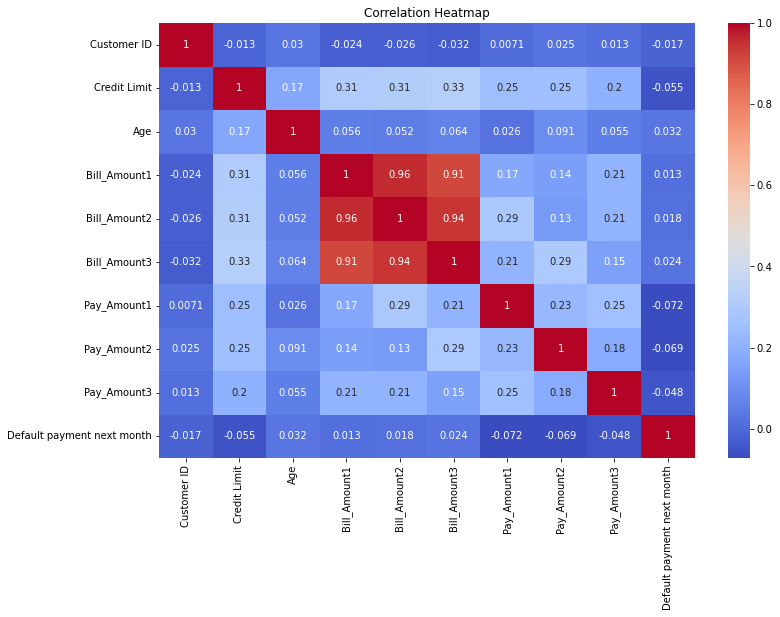

In [9]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(eda_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

* Many classification models assume independence among variables
* The Bill Amounts are all highly correlated (>0.8) with each other and thus not independent

In [10]:
# # Correlation heatmap
# plt.figure(figsize=(12, 8))
# sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
# plt.title('Correlation Heatmap')
# plt.show()

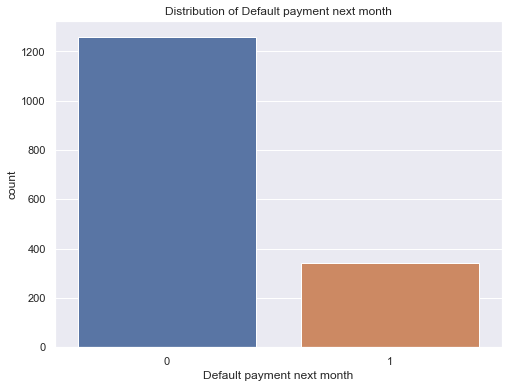

In [11]:
sns.set()

# Distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='Default payment next month', data=eda_df)
plt.title('Distribution of Default payment next month')
plt.show()

In [12]:
# Class Imbalance
target_counts = eda_df['Default payment next month'].value_counts()
class_proportions = target_counts / target_counts.sum()
print('Class Proportions:')
print(class_proportions)

Class Proportions:
0    0.7875
1    0.2125
Name: Default payment next month, dtype: float64


* There is a large class imbalance in favour of 0, otherwise known as the negative class.

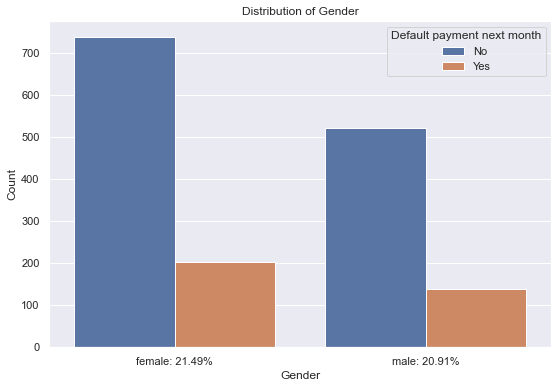

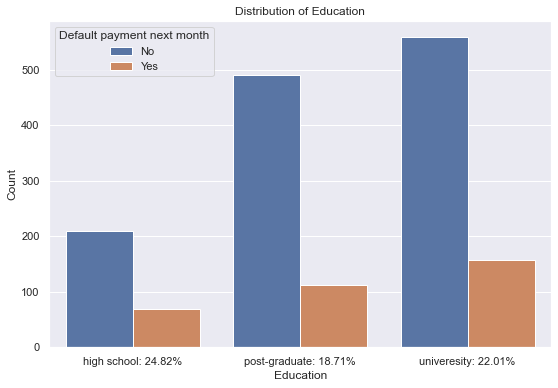

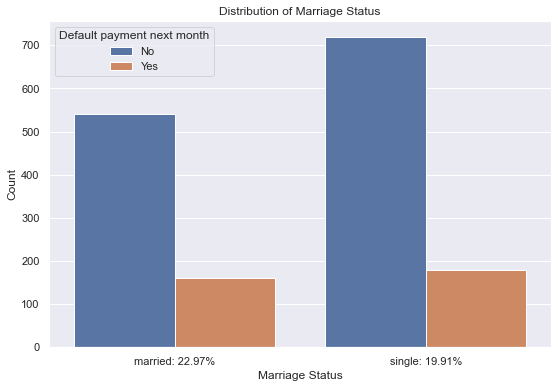

In [68]:
# Distribution of categorical variables
categorical_cols = ['Gender', 'Education', 'Marriage Status']
for col in categorical_cols:
    plt.figure(figsize=(9, 6))
    sns.countplot(x=col, hue='Default payment next month', data=eda_df)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend(title='Default payment next month', labels=['No', 'Yes'])
    
    # Calculate default rate for each category
    default_rate = eda_df.groupby(col)['Default payment next month'].mean()
    
    # Display default rate on the plot
#     for i, rate in enumerate(default_rate):
#         plt.text(i, -30, f'{rate:.2%}', ha='center', va='bottom')
    
    # Set x-axis labels
    plt.xticks(range(len(default_rate)), [f'{idx}: {rate:.2%}' for idx, rate in zip(default_rate.index, default_rate)])
    
    plt.show()

* Females have a slightly higher default rate than males
* Individuals with only a high school education have a higher default rate than those with university education have a higher default rate than those with post-graduate level education
* Married individuals have a higher default rate than singles

In [14]:
from sklearn.preprocessing import StandardScaler

# Create another DataFrame with the same structure
df_target = pd.DataFrame(columns=eda_df.columns).drop(columns=categorical_cols)

# Select columns of type int or float from the source DataFrame
numeric_columns = eda_df.select_dtypes(include=['int', 'float']).columns

# Set the values in the target DataFrame
df_target[numeric_columns] = eda_df[numeric_columns]

#Removing less than or equal to zero
df_target_positive_only = df_target[df_target >= 0].fillna(0)

from sklearn.preprocessing import PowerTransformer

std_scaled_df = pd.DataFrame(StandardScaler().fit_transform(df_target), columns=df_target.columns)
std_scaled_df["Default payment next month"] = df["Default payment next month"]

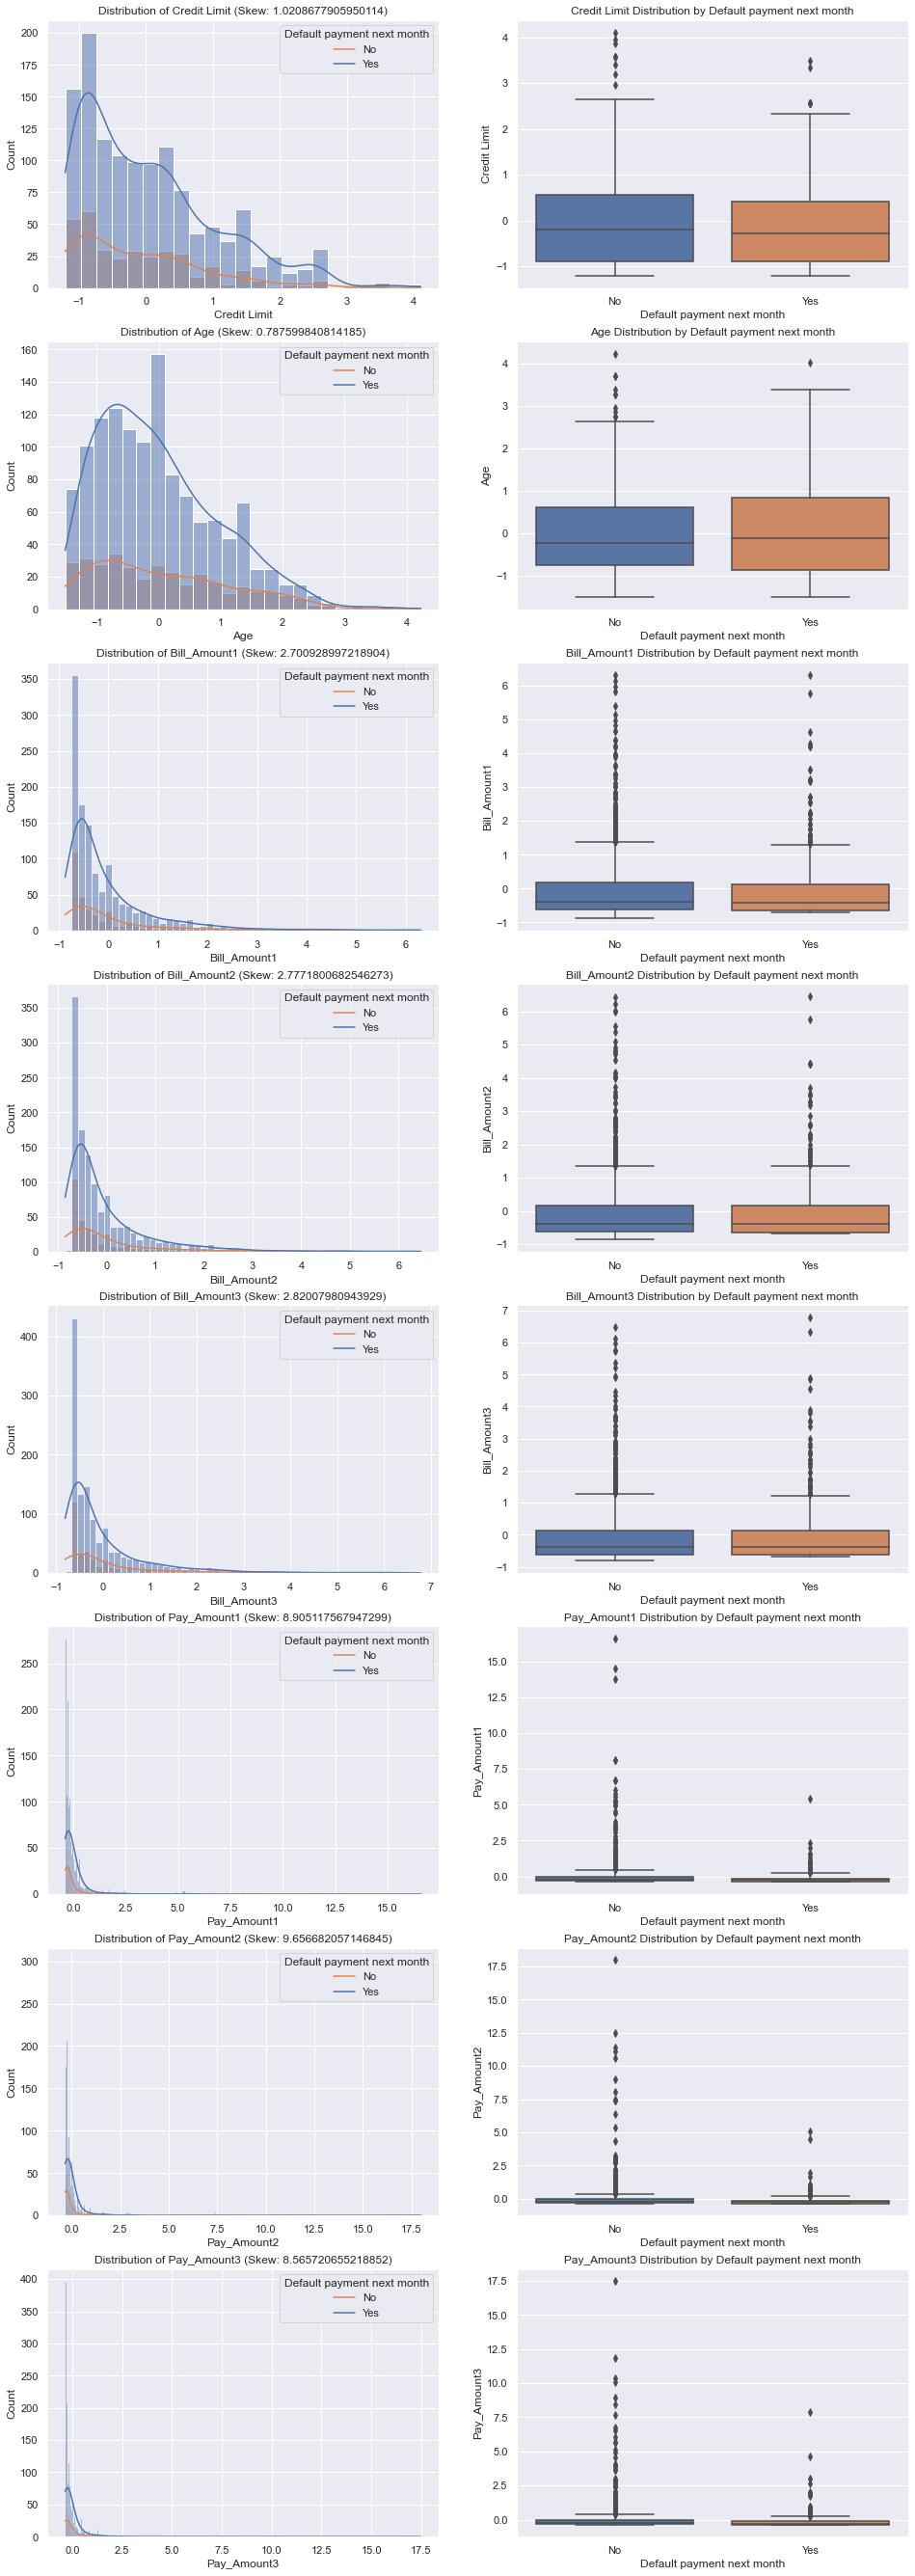

In [69]:
# Distribution of numerical variables
# numerical_cols = ['Credit Limit', 'Age', 'Bill_Amount1', 'Bill_Diff12', 'Bill_Diff23', 'Pay_Amount1', 'Pay_Amount2', 'Pay_Amount3']
numerical_cols = ['Credit Limit', 'Age', 'Bill_Amount1', 'Bill_Amount2', 'Bill_Amount3', 'Pay_Amount1', 'Pay_Amount2', 'Pay_Amount3']

fig, axes = plt.subplots(nrows=len(numerical_cols), ncols=2, figsize=(16, 48))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    histplot_ax = i*2
    boxplot_ax = i*2+1
    
    sns.histplot(data=std_scaled_df, x=col, hue='Default payment next month', kde=True, ax=axes[histplot_ax])
    axes[histplot_ax].set_title(f'Distribution of {col} (Skew: {std_scaled_df[col].skew()})')
    axes[histplot_ax].legend(title='Default payment next month', labels=['No', 'Yes'])
    
    # Box plot for numerical variables by target class
    sns.boxplot(x='Default payment next month', y=col, data=std_scaled_df, ax=axes[boxplot_ax])
    axes[boxplot_ax].set_title(f'{col} Distribution by Default payment next month')
    axes[boxplot_ax].set_xlabel('Default payment next month')
    axes[boxplot_ax].set_ylabel(col)
    axes[boxplot_ax].set_xticklabels(['No', 'Yes'])

plt.show()

* All of the numeric columns are skewed
* Models such as Gaussian Naive Bayes Classifer, Logistic Regression assume normal distribution of data, so it is better to have models without or with less skew (< 0.5)
* We will use the "Yeo-Johnson" Transformer to unskew the data

In [16]:
yj_scaled_df = pd.DataFrame(PowerTransformer(method="yeo-johnson").fit_transform(df_target_positive_only), columns=df_target.columns)
yj_scaled_df["Default payment next month"] = df["Default payment next month"]

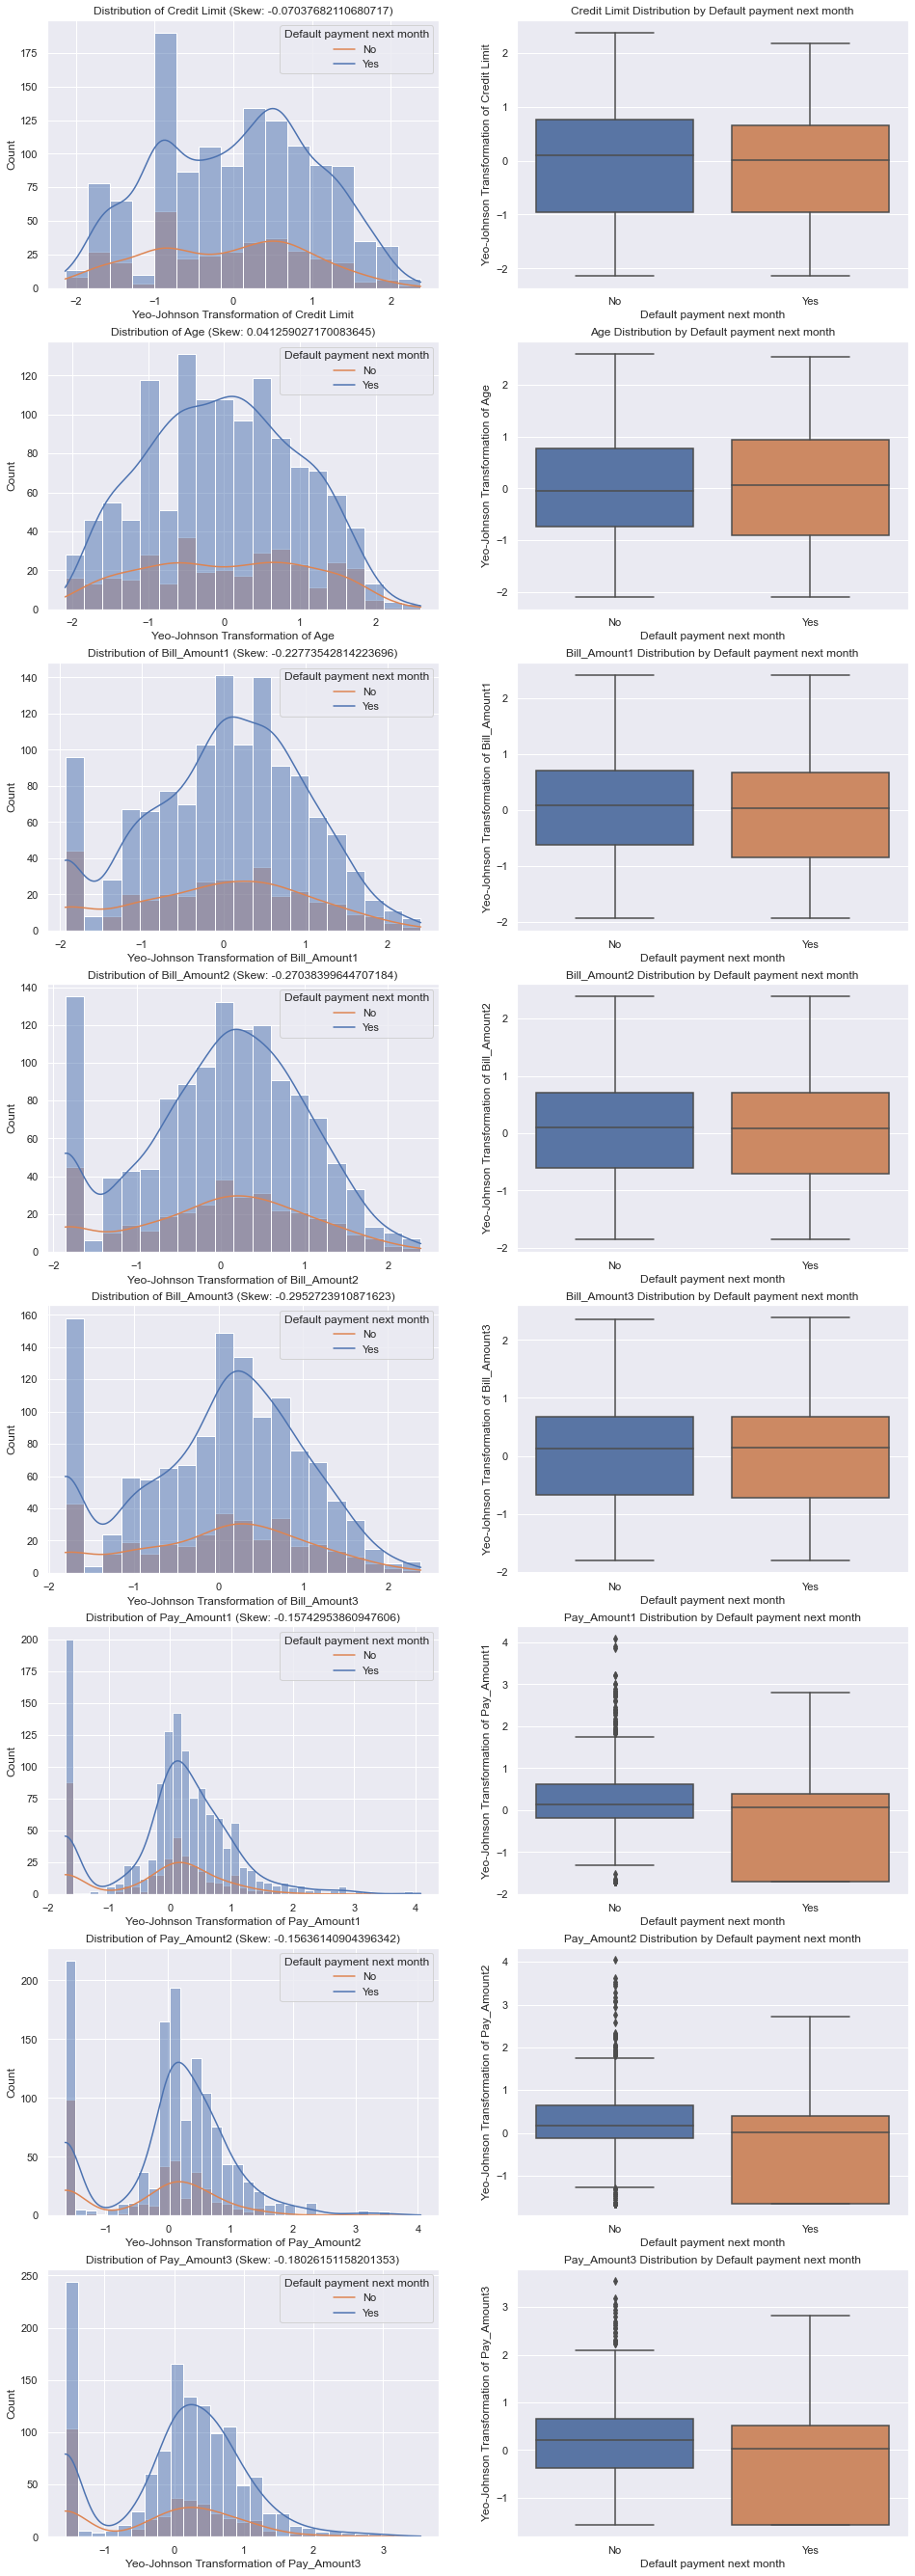

In [17]:
fig, axes = plt.subplots(nrows=len(numerical_cols), ncols=2, figsize=(16, 48))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    histplot_ax = i*2
    boxplot_ax = i*2+1
        
    sns.histplot(data=yj_scaled_df, x=col, hue='Default payment next month', kde=True, ax=axes[histplot_ax])
    axes[histplot_ax].set_title(f'Distribution of {col} (Skew: {yj_scaled_df[col].skew()})')
    axes[histplot_ax].set_xlabel(f'Yeo-Johnson Transformation of {col}')
    axes[histplot_ax].legend(title='Default payment next month', labels=['No', 'Yes'])
    
    # Box plot for numerical variables by target class
    sns.boxplot(x='Default payment next month', y=col, data=yj_scaled_df, ax=axes[boxplot_ax])
    axes[boxplot_ax].set_title(f'{col} Distribution by Default payment next month')
    axes[boxplot_ax].set_xlabel('Default payment next month')
    axes[boxplot_ax].set_ylabel(f'Yeo-Johnson Transformation of {col}')
    axes[boxplot_ax].set_xticklabels(['No', 'Yes'])
    
plt.show()

In [64]:
neg_eda_df = eda_df.copy()
neg_eda_df["Neg_Bill_Amount1"] = (eda_df["Bill_Amount1"] < 0)
neg_eda_df["Neg_Bill_Amount2"] = (eda_df["Bill_Amount2"] < 0)
neg_eda_df["Neg_Bill_Amount3"] = (eda_df["Bill_Amount3"] < 0)

In [74]:
# neg_eda_df["Zero_Bill_Amount1"] = (eda_df["Bill_Amount1"] == 0)
# neg_eda_df["Zero_Bill_Amount2"] = (eda_df["Bill_Amount2"] == 0)
# neg_eda_df["Zero_Bill_Amount3"] = (eda_df["Bill_Amount3"] == 0)
# neg_eda_df["Zero_Pay_Amount1"] = (eda_df["Pay_Amount1"] == 0)
# neg_eda_df["Zero_Pay_Amount2"] = (eda_df["Pay_Amount2"] == 0)
# neg_eda_df["Zero_Pay_Amount3"] = (eda_df["Pay_Amount3"] == 0)

In [75]:
neg_eda_df.sum()

C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/388332255.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  neg_eda_df.sum()


Customer ID                     1280800
Credit Limit                  266860000
Age                               56359
Bill_Amount1                   78821453
Bill_Amount2                   76362631
Bill_Amount3                   71249683
Pay_Amount1                     8876234
Pay_Amount2                     8368791
Pay_Amount3                     7122577
Default payment next month          340
Neg_Bill_Amount1                     35
Neg_Bill_Amount2                     37
Neg_Bill_Amount3                     32
Zero_Bill_Amount1                   105
Zero_Bill_Amount2                   143
Zero_Bill_Amount3                   169
Zero_Pay_Amount1                    287
Zero_Pay_Amount2                    311
Zero_Pay_Amount3                    347
dtype: int64

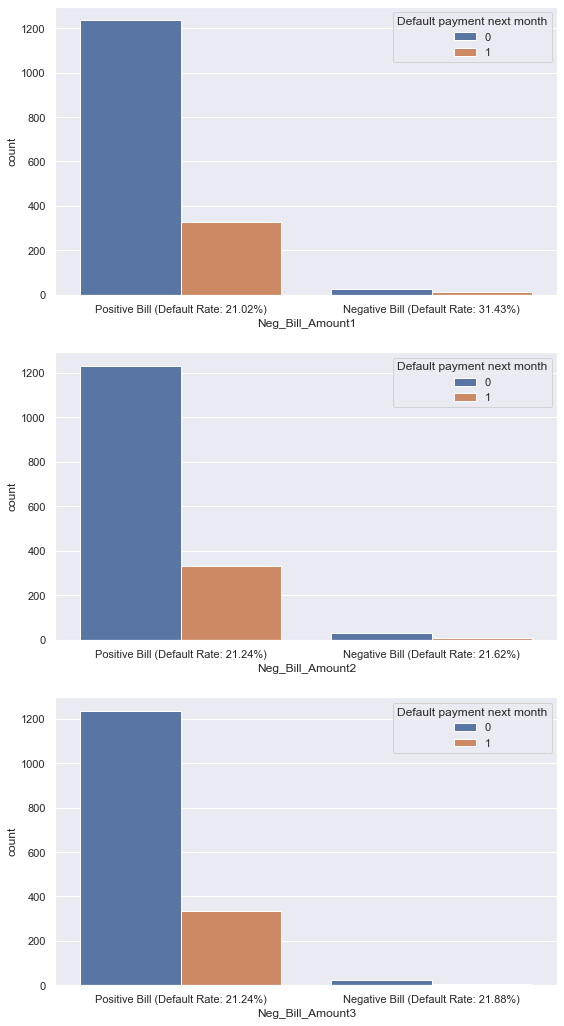

In [139]:
# cols = ["Neg_Bill_Amount1", "Neg_Bill_Amount2", "Neg_Bill_Amount3", "Zero_Bill_Amount1", "Zero_Bill_Amount2", "Zero_Bill_Amount3", "Zero_Pay_Amount1", "Zero_Pay_Amount2", "Zero_Pay_Amount3"]
cols = ["Neg_Bill_Amount1", "Neg_Bill_Amount2", "Neg_Bill_Amount3"]

fig, axes = plt.subplots(nrows=len(cols), ncols=1, figsize=(9, 18))
axes = axes.flatten()

for i, col in enumerate(cols):
    default_rate = neg_eda_df.groupby(col)['Default payment next month'].mean()
    
    # Set x-axis labels
    sns.countplot(hue='Default payment next month', x=col, data=neg_eda_df,ax=axes[i])
    axes[i].set_xticklabels([f'{"Negative Bill" if idx else "Positive Bill"} (Default Rate: {rate:.2%})' for idx, rate in zip(default_rate.index, default_rate)])
    
plt.show()

* Those with negative bills in each month are more likely to default

#### Pearson's r Correlations

To check for correlation between the features and target, we use Pearson's r correlation coefficient. It is able to measure the linear correlation between the two variables.

The r value of X and Y is equal to diving the covriance of X and Y by the product of their standard deviations.

Formula:
\begin{equation}
\rho = \frac{\text{cov}(X,Y)}{\sigma_x \sigma_y}
\end{equation}

\begin{equation}
r = \frac{{}\sum_{i=1}^{n} (x_i - \overline{x})(y_i - \overline{y})}
{\sqrt{\sum_{i=1}^{n} (x_i - \overline{x})^2(y_i - \overline{y})^2}}
\end{equation}

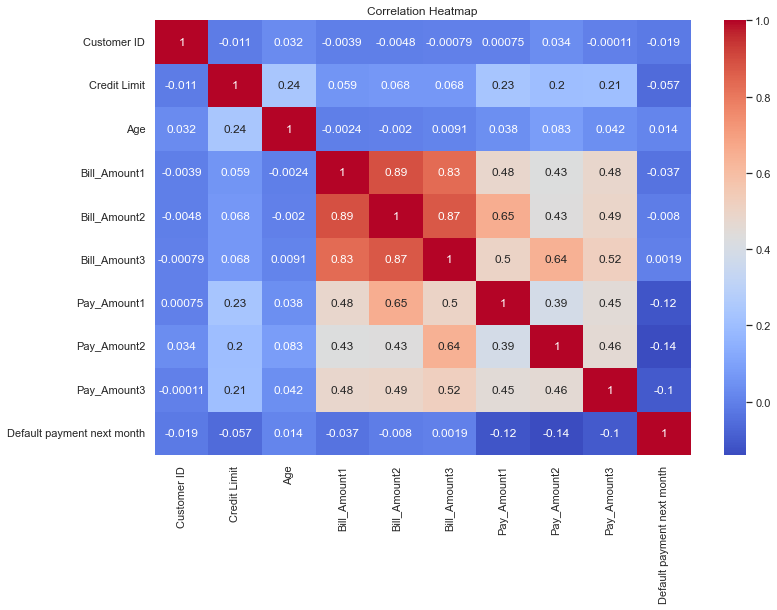

In [18]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(yj_scaled_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

* We can see that the Bill Amounts (Bill_Amount1, Bill_Amount2, Bill_Amount3) are all highly correlated with each other (ranging from 0.83 to 0.89)

### Dropping Redundant Columns
1. Dropping features that are unique (Customer ID) as the values are unique

In [4]:
prep_df = df.drop(columns=["Customer ID"]).replace(to_replace="univeresity", value="university")

## Data Preprocessing & Feature Engineering
1. Add a column for negative bill amounts in the most recent month (Bill_Amount1 < 0).


In [5]:
prep_df["Neg_Bill_Amount1"] = [1 if x else 0 for x in prep_df["Bill_Amount1"] < 0]

2. Add Yeo-Johnson transformation using PowerTransformer, which also helps standardise data.

In [6]:
pt = ("power_transformer", 
      PowerTransformer(method="yeo-johnson", standardize=True), 
      ["Credit Limit","Bill_Amount1", "Bill_Amount2", "Bill_Amount3", "Pay_Amount1", "Pay_Amount2", "Pay_Amount3"]
     )

3. Add One-Hot encoding of "Marital Status" and "Gender".

In [7]:
ohe = ("one_hot_encoder", OneHotEncoder(sparse_output=False), ["Marriage Status", "Gender"])

4. Add Ordinal encoding of "Education".

In [8]:
education = ["high school", "university", "post-graduate"]

oee =  ("ordinal_education_encoder", OrdinalEncoder(categories=[education]), ["Education"])

5. Wrap all the individual transformers with ColumnTransformer so that each transformation is applied only where they are need.

In [9]:
ct = ColumnTransformer(
    transformers=[
        pt, ohe, oee]
)

Creating DataFrames for features and targets

In [10]:
X = prep_df.drop(columns='Default payment next month')
y = df['Default payment next month']
X

,Credit Limit,Gender,Education,Marriage Status,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Neg_Bill_Amount1
0,20000,female,university,married,24,3913,3102,689,0,689,0,0
1,120000,female,university,single,26,2682,1725,2682,0,1000,1000,0
2,90000,female,university,single,34,29239,14027,13559,1518,1500,1000,0
3,50000,female,university,married,37,46990,48233,49291,2000,2019,1200,0
4,50000,male,university,married,57,8617,5670,35835,2000,36681,10000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1595,480000,female,university,married,35,18214,11031,182123,0,182123,12960,0
1596,150000,female,university,married,37,1184,794,2756,0,2772,0,0
1597,110000,female,post-graduate,single,29,107195,109443,106637,7845,4000,4000,0
1598,240000,male,post-graduate,single,30,7744,7284,11234,7305,11263,10018,0


## Model Selection

In [11]:
models = [
    ("DummyClassifier", DummyClassifier(random_state=23)),
    ("DecisionTreeClassifier", DecisionTreeClassifier(random_state=23)),
    ("RandomForestClassifier", RandomForestClassifier(random_state=23)),
    ("GradientBoostingClassifier", GradientBoostingClassifier(random_state=23)),
    ("LogisticRegression", LogisticRegression(random_state=23)),
    ("LinearSVC", LinearSVC()),
    ("SVC", SVC()),
    ("MLPClassifier", MLPClassifier(random_state=23)),
    ("KNeighborsClassifier", KNeighborsClassifier()),
    ("GaussianNB", GaussianNB())
]

https://stackoverflow.com/questions/66922202/confusing-f1-score-and-auc-scores-in-a-highly-imbalanced-data-while-using-5-fo

In [12]:
from sklearn.metrics import make_scorer, precision_recall_curve, f1_score, accuracy_score

def optimized_proba_f1_score(y_valid, proba, return_threshold=False):
    precision, recall, thresholds = precision_recall_curve(y_valid, proba)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    f1_scores = np.nan_to_num(f1_scores)
    if return_threshold:
        return thresholds[f1_scores.argmax()]
    else:
        return f1_scores.max()

opt_pb_f1_scorer = make_scorer(optimized_proba_f1_score, greater_is_better=True, needs_proba=True, return_threshold=False)

def optimized_proba_f1_accuracy_score(y_valid, proba):
    precision, recall, thresholds = precision_recall_curve(y_valid, proba)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    f1_scores = np.nan_to_num(f1_scores)
    best_threshold = thresholds[f1_scores.argmax()]
    return accuracy_score(y_valid, proba >= best_threshold)

opt_pb_f1_acc_scorer = make_scorer(optimized_proba_f1_accuracy_score, greater_is_better=True, needs_proba=True)


def fixed_threshold_f1_score(y_valid, fn, threshold_proba=0.5):
    y_pred = (fn >= threshold_proba).astype(bool)
    return f1_score(y_valid, y_pred)

fixed_pb_f1_scorer = make_scorer(fixed_threshold_f1_score, greater_is_better=True, needs_proba=True, threshold_proba=0.5)

def optimized_decision_function_f1_score(y_valid, decision_function, return_threshold=False):
    threshold_distances = np.linspace(decision_function.min(), decision_function.max(), 100)
#     print(np.shape(y_valid.astype(bool)))
#     print(np.shape(decision_function > 0.001))
    f1_scores = np.array([f1_score(y_valid.astype(bool), decision_function > threshold_distance) for threshold_distance in threshold_distances])
    if return_threshold:
        return threshold_distances[f1_scores.argmax()]
    else:
        return f1_scores.max()
    
opt_th_f1_scorer = make_scorer(optimized_decision_function_f1_score, greater_is_better=True, needs_threshold=True, return_threshold=False)

In [13]:
from sklearn.model_selection import cross_validate
# from sklearn.metrics import f1_score
from imblearn.pipeline import make_pipeline

# pipeline = make_pipeline(prep, resampler, classifier)

def cv_scoring(pipeline, X, y, scoring={}, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), n_jobs=-1):
    cv_scores = cross_validate(pipeline, X, y, scoring=scoring, cv=cv, n_jobs=n_jobs, return_train_score=True)
    avg_scores = {}
    for key, value in cv_scores.items():
        if "test_" in key or "train_" in key:
            avg_scores[key] = np.mean(value)
    return avg_scores

### Scoring Metrics
* F1 Score: Harmonic Mean of Precision and Recall of the Positive Class
\begin{equation}
F_{1} = 2 \cdot \frac{precision \cdot recall}{precision + recall}
\end{equation}

\begin{equation}
precision = \frac{True Positive}{True Positive + False Positive}
\end{equation}

\begin{equation}
recall = \frac{True Positive}{True Positive + False Negative}
\end{equation}

\begin{equation}
F_{1} = \frac{2 \cdot True Positive}{2 \cdot True Positve + False Positive + False Negative}
\end{equation}

* Average Precision: The area under the precision recall curve.

* Accuracy: 
\begin{equation}
accuracy = \frac{True Positive + True Negative}{True Positive + True Negative + False Positive + False Negative}
\end{equation}
<br>
I will mainly be focussing on the F1 score since in my various experimentation during hyperparameter tuning, tuning with Average Precision as the metric can sometimes yield me a model that's extremely biased towards the Positive (1s) class. <br>
I do not use Accuracy for hyperparameter tuning since the imbalanced data will yield a high accuracy if the model picks the majority class only.

## References:
1. neptune.ai. 2023. F1 Score vs ROC AUC vs Accuracy vs PR AUC: Which Evaluation Metric Should You Choose? [Accessed 9 June 2023].
https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc

### KFold Cross Validation and Stratification
* I will use cross-validation with different splits of data so that it's less likely for the model I select to be overfit.
* I will be using stratification for all my evaluations so that each split has the same representation and distribution of 1s and 0s.
* This means that for cross-validation, StratifiedKFold is used. For my evaluation of models, I use a greater number of splits (n=20) since a higher number of splits means a larger train set and smaller test set in each split. However, when I perform hyperparameter tuning I will use a smaller number of splits (n=5) to speed up the process.

### Handling Imbalanced Data with Resampling

To compensate for the class imbalance in the data, I will be comparing the various methods of resampling to compensate for the imbalance.
* No Resampling: the "default", no resampling
* RandomUnderSampler: resamples the majority class to match the count of the minority class
* RandomOversSampler: resamples the minority class to match the count of the majority class by randomly repeating values
* SMOTE: Synthetic Minority Oversampling Technique resamples the minority class and creates new samples based on statistical methods 
* SMOTE-NC: Synthetic Minority Oversampling Technique for Nominal and Continuous resamples the minority class and creates new samples based on statistical methods, nominal columns will also be sampled accordingly.

In [14]:
# from tqdm.notebook import tqdm
from imblearn.pipeline import make_pipeline

def model_scores(resampler=None):
    cv_scores = []
    for estimator_idx in tqdm(range(len(models)), desc=desc, position=1):
        (estimator_name, estimator) = models[estimator_idx]
        if not isinstance(estimator, Pipeline): 
            if resampler == None:
                estimator = make_pipeline(ct, estimator)
            else:
                estimator = make_pipeline(ct, resampler, estimator)
        cv_scores.append({"model": estimator_name})
        cv_scores[estimator_idx].update(
            cv_scoring(
                estimator, 
                X, 
                y, 
                scoring={
                    "opt_proba_f1": opt_pb_f1_scorer,
                    "opt_th_f1": opt_th_f1_scorer,
                    "f1": "f1",
                    "ap": "average_precision",
                    "accuracy": "accuracy",
                    "opt_acc": opt_pb_f1_acc_scorer,
                    "roc_auc": "roc_auc",
                    "recall": "recall",
                    "precision": "precision"
                },
                cv=StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
            )
        )
    return cv_scores

In [18]:
resamplers = [
    ("No resampling (Control)", None),
    ("RandomUnderSampler", RandomUnderSampler(random_state=42)),
    ("RandomOverSampler", RandomOverSampler(random_state=42)),
    ("SMOTE", SMOTE(random_state=42)),
     ("SMOTENC", SMOTENC(categorical_features=[7, 8, 9], random_state=42))
#     ("SMOTENC", SMOTENC(categorical_features=[7, 8, 9, 10, 11], random_state=42))
]

resampled_model_scores = {}
for resampler_idx in tqdm(range(len(resamplers)), desc="Scoring", position=0):
    (resampler_name, resampler) = resamplers[resampler_idx]
    desc=f"Resampling Method: {resampler_name}"
    resampled_model_scores[resampler_name] = model_scores(resampler)

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Resampling Method: No resampling (Control):   0%|          | 0/10 [00:00<?, ?it/s]

Resampling Method: RandomUnderSampler:   0%|          | 0/10 [00:00<?, ?it/s]

Resampling Method: RandomOverSampler:   0%|          | 0/10 [00:00<?, ?it/s]

Resampling Method: SMOTE:   0%|          | 0/10 [00:00<?, ?it/s]

Resampling Method: SMOTENC:   0%|          | 0/10 [00:00<?, ?it/s]

ValueError: 
All the 20 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Admin\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\Admin\anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\Admin\anaconda3\lib\site-packages\imblearn\pipeline.py", line 422, in _fit_resample_one
    X_res, y_res = sampler.fit_resample(X, y, **fit_params)
  File "C:\Users\Admin\anaconda3\lib\site-packages\imblearn\base.py", line 203, in fit_resample
    return super().fit_resample(X, y)
  File "C:\Users\Admin\anaconda3\lib\site-packages\imblearn\base.py", line 88, in fit_resample
    output = self._fit_resample(X, y)
  File "C:\Users\Admin\anaconda3\lib\site-packages\imblearn\over_sampling\_smote\base.py", line 633, in _fit_resample
    X_resampled, y_resampled = super()._fit_resample(X_encoded, y)
  File "C:\Users\Admin\anaconda3\lib\site-packages\imblearn\over_sampling\_smote\base.py", line 355, in _fit_resample
    nns = self.nn_k_.kneighbors(X_class, return_distance=False)[:, 1:]
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 824, in kneighbors
    results = ArgKmin.compute(
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_pairwise_distances_reduction\_dispatcher.py", line 277, in compute
    return ArgKmin64.compute(
  File "sklearn\metrics\_pairwise_distances_reduction\_argkmin.pyx", line 95, in sklearn.metrics._pairwise_distances_reduction._argkmin.ArgKmin64.compute
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\utils\fixes.py", line 139, in threadpool_limits
    return threadpoolctl.threadpool_limits(limits=limits, user_api=user_api)
  File "C:\Users\Admin\anaconda3\lib\site-packages\threadpoolctl.py", line 171, in __init__
    self._original_info = self._set_threadpool_limits()
  File "C:\Users\Admin\anaconda3\lib\site-packages\threadpoolctl.py", line 268, in _set_threadpool_limits
    modules = _ThreadpoolInfo(prefixes=self._prefixes,
  File "C:\Users\Admin\anaconda3\lib\site-packages\threadpoolctl.py", line 340, in __init__
    self._load_modules()
  File "C:\Users\Admin\anaconda3\lib\site-packages\threadpoolctl.py", line 373, in _load_modules
    self._find_modules_with_enum_process_module_ex()
  File "C:\Users\Admin\anaconda3\lib\site-packages\threadpoolctl.py", line 485, in _find_modules_with_enum_process_module_ex
    self._make_module_from_path(filepath)
  File "C:\Users\Admin\anaconda3\lib\site-packages\threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "C:\Users\Admin\anaconda3\lib\site-packages\threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "C:\Users\Admin\anaconda3\lib\site-packages\threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


* Models based on Support Vector Machines (SVMs) such as LinearSVC and SVC do not have a predict_proba function, to give probabilities for each class, they only have a decision_function. Thus I calculated the optimized threshold for Probability as well as the Decision Function and substituted the NaN values in LinearSVC and SVC

In [226]:
for key, values in resampled_model_scores.items():
    values = pd.DataFrame(values)
    for idx in values.loc[pd.isna(values["test_opt_proba_f1"]), :].index:
        values.iloc[idx, 1] = values.iloc[idx, 3] #set optimized proba f1 score to optimized threshold f1 score
        resampled_model_scores[key] = values

In [230]:
sorted_resampled_model_scores = {}
for key, values in resampled_model_scores.items():
    values = pd.DataFrame(values)
    sorted_resampled_model_scores[key] = values.sort_values(by=["test_opt_proba_f1"], axis=0, ascending=False) # sort by optimized f1 score

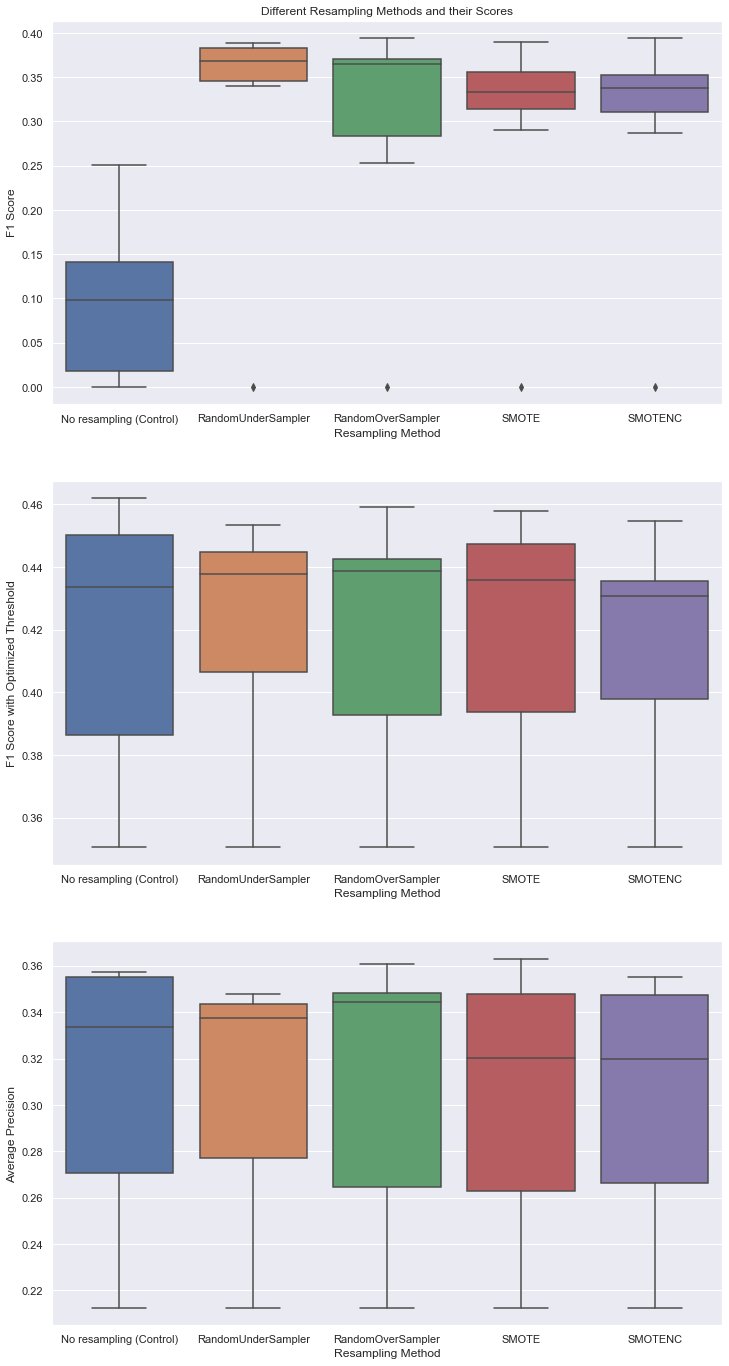

In [232]:
sns.set()

metrics = ["test_f1", "test_opt_proba_f1", "test_ap"]
ylabels = ["F1 Score", "F1 Score with Optimized Threshold", "Average Precision"]
fig, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(12, len(metrics)*8))
axes = axes.flatten()

axes[0].set_title("Different Resampling Methods and their Scores")

for i, metric in enumerate(metrics):
    melted = []
    for key, values in sorted_resampled_model_scores.items():
        for value in values[metric]:
            melted.append([key, value])
    melted_df = pd.DataFrame(melted, columns=["x", "y"])
    sns.boxplot(x="x", y="y", data=melted_df, ax=axes[i])
    axes[i].set_xlabel("Resampling Method")
    axes[i].set_ylabel(ylabels[i])
    
plt.show()

* We find the "optimal" threshold value by finding the corresponding F1 score for each threshold.
* Random over sampling is the best method based on the median "optimized" F1 score, it is likely to improve the models more.

In [233]:
resampled_model_scores["RandomOverSampler"]

,model,test_opt_proba_f1,train_opt_proba_f1,test_opt_th_f1,train_opt_th_f1,test_f1,train_f1,test_ap,train_ap,test_accuracy,train_accuracy,test_opt_acc,train_opt_acc,test_roc_auc,train_roc_auc,test_recall,train_recall,test_precision,train_precision
4,LogisticRegression,0.459008,0.415415,0.447796,0.409936,0.394023,0.405680,0.347692,0.327035,0.607500,0.616842,0.577500,0.568388,0.649486,0.661031,0.605882,0.615480,0.293117,0.302606
5,LinearSVC,0.448720,NaN,0.448720,0.410708,0.389783,0.405807,0.347188,0.326756,0.602500,0.615099,NaN,NaN,0.650140,0.661035,0.602941,0.618576,0.289156,0.302003
2,RandomForestClassifier,0.443225,0.994382,0.443225,0.994382,0.271188,0.994381,0.360922,0.999274,0.770625,0.997599,0.627500,0.997599,0.619468,0.999819,0.205882,0.999845,0.444303,0.988979
3,GradientBoostingClassifier,0.441006,0.670447,0.437271,0.666787,0.364652,0.652327,0.348455,0.718522,0.670625,0.816711,0.583750,0.848586,0.614776,0.898393,0.447059,0.809133,0.311641,0.546591
9,GaussianNB,0.440097,0.399637,0.436542,0.398197,0.364893,0.373511,0.310344,0.290440,0.597500,0.599211,0.551250,0.512138,0.610971,0.631194,0.541176,0.562539,0.276555,0.279735
7,MLPClassifier,0.437154,0.570151,0.433195,0.567354,0.364568,0.557660,0.349801,0.585492,0.647500,0.751118,0.618750,0.784441,0.623436,0.833549,0.479412,0.737771,0.298004,0.448545
6,SVC,0.430674,NaN,0.430674,0.475177,0.372478,0.464089,0.341672,0.428449,0.608125,0.669704,NaN,NaN,0.615266,0.748137,0.547059,0.673220,0.285276,0.354765
8,KNeighborsClassifier,0.380164,0.646299,0.376703,0.646299,0.321772,0.584824,0.249093,0.719073,0.553125,0.730625,0.468125,0.836217,0.550187,0.896168,0.500000,0.892724,0.238093,0.434908
1,DecisionTreeClassifier,0.360472,0.994382,0.253137,0.994382,0.252582,0.994379,0.230125,0.999901,0.686875,0.997599,0.315625,0.997599,0.528035,0.999981,0.255882,0.999381,0.253677,0.989429
0,DummyClassifier,0.350515,0.350515,0.000000,0.000000,0.000000,0.000000,0.212500,0.212500,0.787500,0.787500,0.212500,0.212500,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000


### Baseline Score

In [234]:
X_80, X_test, y_80, y_test = train_test_split(X, y, test_size=0.2, random_state=53, stratify=y)

# establishing baselines
from sklearn.metrics import confusion_matrix

print("From DummyClassifier:")
print(optimized_proba_f1_score(y_test, y_pred))

all_zeros = np.zeros(len(y_test))
print("\nIf all predications are zeros:")
print(confusion_matrix(y_test, all_zeros))
print(f1_score(y_test, all_zeros))

all_ones = np.ones(len(y_test))
print("\nIf all predications are ones:")
print(confusion_matrix(y_test, all_ones))
print(f1_score(y_test, all_ones))

dum_clf = DummyClassifier()
dum_clf.fit(X_80, y_80)
y_pred = dum_clf.predict(X_test)

From DummyClassifier:
0.3505154639175258

If all predications are zeros:
[[252   0]
 [ 68   0]]
0.0

If all predications are ones:
[[  0 252]
 [  0  68]]
0.3505154639175258


* The baseline for F1 score with optimized threshold should be 0.3505154639175258 since that is the outcome when all predictions are of the Positive (ones) class.

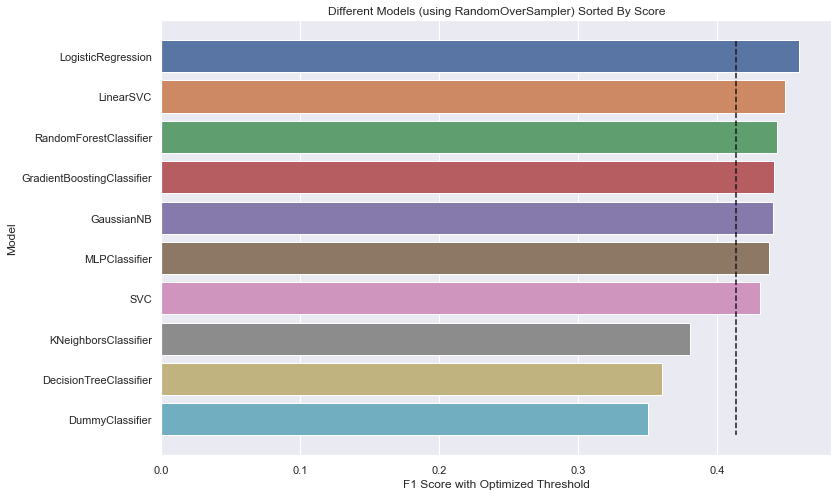

In [452]:
# Show all the average precision scores from different models
plt.figure(figsize=(12, 8))
sns.barplot(y="model", 
            x="test_opt_proba_f1", 
            data=sorted_resampled_model_scores["RandomOverSampler"]
           )
plt.title("Different Models (using RandomOverSampler) Sorted By Score")
plt.ylabel("Model")
plt.xlabel("F1 Score with Optimized Threshold")
# plt.xticks(rotation=15)

baseline = optimized_proba_f1_score(y_test, y_pred)
plt.plot([baseline, baseline], [-0.38, 9.38], "k--")
plt.show()

**Observations**
* All models perform better than the baseline from DummyClassifier
* Best Performing Untuned Models:
    1. LogisticRegression
    2. LinearSVC
    3. RandomForestClassifier

In [282]:
X_80, X_test, y_80, y_test = train_test_split(X, y, test_size=0.2, random_state=53, stratify=y)

pipeline = make_pipeline(ct, RandomOverSampler(random_state=42), LogisticRegression(random_state=3))

opt_pb_f1_scorer_with_threshold = make_scorer(optimized_proba_f1_score, 
                                              greater_is_better=True, 
                                              needs_proba=True,
                                              return_threshold=True)

thresholds = cv_scoring(pipeline, X, y, scoring={"threshold": opt_pb_f1_scorer_with_threshold}, cv=StratifiedKFold(n_splits=100, shuffle=True, random_state=42))
print("Best Threshold: ", thresholds['test_threshold'])

Best Threshold:  0.5087817428845473


Confusion Matrix of the best Untuned Model: 



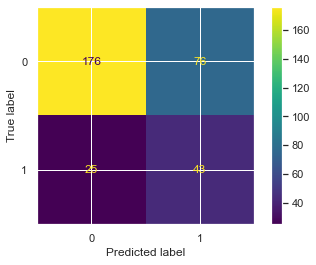

F1 Score:  0.45989304812834225


In [288]:
from sklearn.metrics import ConfusionMatrixDisplay

pipeline.fit(X_80, y_80)
y_pred = pipeline.predict_proba(X_test)[:, -1] >= thresholds['test_threshold']
print("Confusion Matrix of the best Untuned Model: \n")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()
print("F1 Score: ", f1_score(y_test, y_pred))

## Model Improvement <br>
### Hyperparameter Tuning <br>
### GridSearchCV
* I will only be tuning the 3 best performing models.

In [221]:
all_model_grids = [
    {
        "estimator": LogisticRegression(random_state=23),
        "hyperparameter_grid": {
            "logisticregression__penalty": ["l2", None],
            'logisticregression__tol': [1e-3, 1e-4, 1e-5],
            'logisticregression__C': [1, 10, 100],
            "logisticregression__solver": ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"],
            "logisticregression__max_iter": [100, 1000],
            "logisticregression__fit_intercept": [True],
            "logisticregression__dual": [True]
        }
    },
    {
        'estimator': LinearSVC(random_state=23),
        'hyperparameter_grid': {
            'linearsvc__penalty': ['11', 'l2'],
            'linearsvc__loss': ['squared_hinge'],
            'linearsvc__dual': [True, False],
            'linearsvc__tol': [1e-3, 1e-4, 1e-5],
            'linearsvc__C': [1, 10, 100, 1000],
            'linearsvc__intercept_scaling': [0.1, 1, 10]
        }
    },
    {
        'estimator': RandomForestClassifier(random_state=23, n_jobs=-1),
        'hyperparameter_grid': {
            'randomforestclassifier__n_estimators': [100, 500, 1000],
            'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss'],
            'randomforestclassifier__max_depth': [2, 4],
            'randomforestclassifier__min_samples_split': [2, 4, 8],
            'randomforestclassifier__min_samples_leaf': [1, 2, 4, 8]
        }
    },
#     {
#         'estimator': GradientBoostingClassifier(random_state=23),
#         'hyperparameter_grid': {
#             'gradientboostingregressor__log_loss': ['log_loss', 'lad', 'huber', 'quantile'],
#             'gradientboostingregressor__learning_rate': [0.001, 0.01, 0.1, 1],
#             'gradientboostingregressor__n_estimators': [200, 400, 800],
#             'gradientboostingregressor__criterion': ['squared_error', 'friedman_mse'],
#             'gradientboostingregressor__max_depth': [3, 6],
#             'gradientboostingregressor__min_samples_split': [2, 4, 8],
#             'gradientboostingregressor__min_samples_leaf': [1, 3, 5],
#             'gradientboostingregressor__max_features': ['sqrt', 'log2']
#         }
#     }
]

In [225]:
import pickle

tuned_models_gridsearch = []
for i, model_grid in enumerate(all_model_grids):
    pipeline = make_pipeline(ct, RandomOverSampler(random_state=42) model_grid["estimator"])
    tuned_models_gridsearch.append(GridSearchCV(pipeline,
                                               model_grid['hyperparameter_grid'],
                                               scoring=opt_pb_f1_scorer,
#                                                n_jobs=-1,
                                               refit=True,
                                               cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                               verbose=1
                                               )
                                  )
    tuned_models_gridsearch[i].fit(X_80, y_80)
    print(f"Best Score: {tuned_models_gridsearch[i].best_score_}")
    print(f"Best Params: {tuned_models_gridsearch[i].best_params_}")
    pickle.dump(tuned_models_gridsearch[i], open(f'pickled/GridSearchCV/{model_grid["estimator"].__class__.__name__}.pkl', 'wb'))

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountere

C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountere

C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountere

C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountere

C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountere

C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountere

C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountere

C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountere

C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountere

C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountere

C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountere

C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountere

C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountere

C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountere

C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountere

C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountere

C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountere

C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountere

C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountere

C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountere

C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountere

C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountere

C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountere

C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountere

C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountere

C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountere

C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
C:\Users\wugle\AppData\Local\Temp/ipykernel_9388/245728841.py:5: RuntimeWarning: invalid value encountere

Best Score: 0.4312278937117571
Best Params: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__min_samples_leaf': 8, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 400}


* I use pickle to store the model settings so I do not have to rerun the tuning stage, which is very computationally expensive and time consuming.

### Artificial Bee Colony Algorithm

In [415]:
all_model_settings = [
    {
        "estimator": RandomForestClassifier,
        "tunable_space": {
            "n_estimators": (10, 2000, "int"),
            "criterion": (["gini", "entropy", "log_loss"], "str"),
            "min_samples_split": (2, 20, "int"),
            "min_samples_leaf": (1, 20, "int"),
            "min_weight_fraction_leaf": (0, 0.5, "float"),
            "max_features": (["sqrt", "log2"], "str"),
            "min_impurity_decrease": (0, 5, "float"),
            "ccp_alpha": (0, 0.5, "float")
        },
        "default_hyperparameters": {
            "n_estimators": 100,
            "criterion": "gini",
            "min_samples_split": 2,
            "min_samples_leaf": 1,
            "min_weight_fraction_leaf": 0,
            "max_features": "sqrt",
            "min_impurity_decrease": 0,
            "ccp_alpha": 0
        },
        "common_parameters": {
            "n_jobs": -1,
            "random_state": 23
        },
        "scorer": opt_pb_f1_scorer
    },
    {
        "estimator": LinearSVC,
        "tunable_space": {
            "penalty": (["l1", "l2"], "str"),
#             "loss": (["hinge", "squared_hinge"], "str"),
            "tol": (0.00001, 1, "float"),
            "C": (0.1, 10000, "float"),
            "intercept_scaling": (1, 200, "int"),
            "max_iter": (0, 10000, "int")
        },
        "default_hyperparameters": {
            "penalty": "l2",
#             "loss": "squared_hinge",
            "tol": 0.0001,
            "C": 1,
            "intercept_scaling": 1,
            "max_iter": 1000
        },
        "common_parameters": {
            "random_state": 23,
            "dual": False
        },
        "scorer": opt_th_f1_scorer
    },
    {
        "estimator": LogisticRegression,
        "tunable_space": {
            "penalty": (["l2"], "str"),
#             "dual": ([True, False], "str"),
            "tol": (0.00001, 1, "float"),
            "C": (0.1, 1000, "float"),
            "max_iter": (0, 10000, "int"),
            "solver": (["liblinear"], "str")
        },
        "default_hyperparameters": {
            "penalty": "l2",
            "tol": 0.0001,
            "C": 1,
            "max_iter": 100,
            "solver": "liblinear"
        },
        "common_parameters": {
            "dual": False,
            "fit_intercept": True,
            "random_state": 23
        },
        "scorer": opt_pb_f1_scorer
    }
]


common_params = {
#     "n_jobs": -1
}

In [416]:
class Bee:
    def __init__(self, params, score, stay_limit, employed):
        self._params = params
        self._score = score
        self._is_employed = employed
        self._stay_limit = stay_limit
        self._abandon_count = 0
        # print(f'stay limit: {self._stay_limit}')
        
    def abandon(self):
        self._abandon_count += 1
        if self._abandon_count >= self._stay_limit:
            return True
        else:
            return False
        
    def is_better_food(self, new_score):
        if new_score > self._score:
            return True
        else:
            return False

from multiprocess import Pool
from bisect import bisect

class ArtificalBeeColony:
    def __init__(self,
                 estimator,
                 search_space,
                 common_params, 
                 default_params, 
                 fitness_fn, 
                 fitness_fn_params, 
                 n_employed_bees, 
                 n_processes, 
                 scoring_metric,
                 stay_limit=5, 
                 baseline_score=0, 
                 mutation_chance=0.5, 
                 mutation_std=0.1, 
                 ignore_warnings=True
                ):
        self._estimator = estimator
        self._search_space = search_space
        self._common_params = common_params
        self._default_params = default_params
        self._fitness_fn = fitness_fn
        self._fitness_fn_params = fitness_fn_params
        self._scoring_metric = scoring_metric
        self._n_employed_bees = n_employed_bees
        self._best_score = 0
        self._best_params = None
        self._n_processes = n_processes
        self._mutation_chance = mutation_chance
        self._mutation_std = mutation_std
        self._stay_limit = stay_limit
        self._baseline_score = baseline_score
        self._ignore_warnings = ignore_warnings
        self._bees = []
    
    def score(self, params):
#         print(**params, **common_params)
        self._estimator[-1].set_params(**params, **self._common_params)
        if self._ignore_warnings:
            score = None
            try: 
                score = self._fitness_fn(self._estimator, **self._fitness_fn_params)[self._scoring_metric]
                return (params, score)
            except KeyboardInterrupt as err:
                raise KeyboardInterrupt(err)
            except:
                return (params, self._baseline_score)
        else:
            score = self._fitness_fn(self._estimator, **self._fitness_fn_params)[self._scoring_metric]
            return (params, score)
        
#     def employed_bees_eval(self):
    
    def clamp(self, value, range):
        if value > range[1]:
            value = range[1]
        if value < range[0]:
            value = range[0]
        return value

    def random_food(self):
        food = {}
        for key, value in self._search_space.items():
            if value[-1] == "int":
                food[key] = np.random.randint(value[0], value[1])
            elif value[-1] == "float":
                food[key] = np.random.uniform(value[0], value[1])
            elif value[-1] == "str":
                food[key] = np.random.choice(value[0])
            elif value[-1] == "arr":
                food[key] = np.random.randint(value[0], value[1], size=np.random.randint(1, value[2]))

            if value[-1] == "int" or value[-1] == "float":
                food[key] = self.clamp(food[key], value)
            if value[-1] == "arr":
                food[key] = [self.clamp(x, value) for x in food[key]]
        return food
    
    def mutate_food(self, params):
        food = {}
        for key, value in self._search_space.items():
            if random.random() < self._mutation_chance:
                if params[key] == 0:
                    mute_param = 1
                else:
                    mute_param = params[key]
                if value[-1] == "int":
                    food[key] = int(params[key] + mute_param * np.random.normal(loc=0, scale=self._mutation_std))
                elif value[-1] == "float":
                    food[key] = params[key] + mute_param * np.random.normal(loc=0, scale=self._mutation_std)
                elif value[-1] == "str":
                    food[key] = np.random.choice(value[0])
                elif value[-1] == "arr":
                    food[key] = [int(x + x * np.random.normal(loc=0, scale=self._mutation_std)) for x in params[key]]

                if value[-1] == "int" or value[-1] == "float":
                    food[key] = self.clamp(food[key], value)
                if value[-1] == "arr":
                    food[key] = [self.clamp(x, value) for x in food[key]]
            else:
                food[key] = params[key]
        return food

    def choose_bee(self):
        lowest_score = np.min([b._score for b in self._bees])
        fitness_sum = sum((b._score - lowest_score) for b in self._bees)
        if fitness_sum == 0:
            idx = np.random.randint(len(self._bees))
        else:
            probabilities = [(b._score - self._baseline_score) / fitness_sum for b in self._bees]
            cdf_vals = []
            cumsum = 0
            for p in probabilities:
                cumsum += p
                cdf_vals.append(cumsum)
            idx = bisect(cdf_vals, random.random())
        # print(self._bees[idx] == self.best())
        return self._bees[idx]

    def best(self):
        idx = np.argmax([b._score for b in self._bees])
        # print([b._score for b in self._bees])
        return self._bees[idx]
    
    def init_colony(self):
        self._bees = []

        if self._n_processes > 1:
            bee_pool = Pool(processes=self._n_processes)
        employed_results = []
            
        for _ in range(self._n_employed_bees-1):
            params = self.random_food()
            if self._n_processes > 1:
                employed_results.append(bee_pool.apply_async(
                    self.score, [params]
                ))
            else:
                employed_results.append(self.score(
                    params
                ))
                
        if self._n_processes > 1:
            bee_pool.close()
            bee_pool.join()
            employed_results = [r.get() for r in employed_results]
            
        for result in employed_results:

            self._bees.append(Bee(
                result[0],
                result[1],
                self._stay_limit,
                True
            ))
        
        
        self._bees.append(Bee(
            self._default_params,
            self.score(self._default_params)[1],
            True,
            self._stay_limit)
        )

        # print(self._bees[-1]._score)
          
        if self._n_processes > 1:
            bee_pool = Pool(processes=self._n_processes)
        onlooker_results = []

        for _ in range(self._n_employed_bees):

            chosen_employed = self.choose_bee()
            neighbor_food = self.mutate_food(
                chosen_employed._params
            )

            if self._n_processes > 1:
                onlooker_results.append(bee_pool.apply_async(
                    self.score, [params]
                ))
            else:
                onlooker_results.append(self.score(
                    params
                ))

        if self._n_processes > 1:

            bee_pool.close()
            bee_pool.join()
            onlooker_results = [r.get() for r in onlooker_results]

        for result in onlooker_results:

            self._bees.append(Bee(
                result[0],
                result[1],
                self._stay_limit,
                False
            ))
  
    def next_generation(self):
        if self._n_processes > 1:
            bee_pool = Pool(processes=self._n_processes)
        new_employed_results = []
        new_onlooker_results = []
        new_position_results = []
        current_positions = []
        best_bee = self.best()

        next_bee_generation = []

        for bee in self._bees:

            if bee == best_bee:

                next_bee_generation.append(bee)

            else:
                if bee.abandon():

                    if bee._is_employed:

                        new_params = self.random_food()
                        if self._n_processes > 1:
                            new_employed_results.append(bee_pool.apply_async(
                                self.score,
                                [new_params,]
                            ))
                        else:
                            new_employed_results.append(self.score(
                                new_params
                            ))

                    else:

                        chosen_bee = self.choose_bee()
                        neighbor_food = self.mutate_food(
                            chosen_bee._params
                        )
                        if self._n_processes > 1:
                            new_onlooker_results.append(bee_pool.apply_async(
                                self.score,
                                [neighbor_food]
                            ))
                        else:
                            new_onlooker_results.append(self.score(
                                neighbor_food
                            ))

                else:

                    current_positions.append(bee)

                    if bee._is_employed:
                        neighbor_food = self.mutate_food(bee._params)
                    else: 
                        chosen_bee = self.choose_bee()
                        neighbor_food = self.mutate_food(
                            chosen_bee._params
                        )
                    if self._n_processes > 1:
                        new_position_results.append(bee_pool.apply_async(
                            self.score,
                            [neighbor_food]
                        ))
                    else:
                        new_position_results.append(self.score(
                            neighbor_food
                        ))


        if self._n_processes > 1:

            bee_pool.close()
            bee_pool.join()
            new_employed_results = [r.get() for r in new_employed_results]
            new_onlooker_results = [r.get() for r in new_onlooker_results]
            new_position_results = [r.get() for r in new_position_results]

        for result in new_employed_results:

            next_bee_generation.append(Bee(
                result[0],
                result[1],
                self._stay_limit,
                True
            ))

        for result in new_onlooker_results:

            next_bee_generation.append(Bee(
                result[0],
                result[1],
                self._stay_limit,
                False
            ))

        for idx, result in enumerate(new_position_results):

            bee_to_compare = current_positions[idx]
            if bee_to_compare.is_better_food(result[1]):
                if bee._is_employed:
                    next_bee_generation.append(Bee(
                        result[0],
                        result[1],
                        self._stay_limit,
                        True
                    ))
                else:
                    next_bee_generation.append(Bee(
                        result[0],
                        result[1],
                        self._stay_limit,
                        False
                    ))
            else:
                next_bee_generation.append(bee_to_compare)

        self._bees = next_bee_generation
            
    def fit(self, n_iter, threshold, verbose=True):
        print("Initializing Bee Colony...")
        self.init_colony()
        from tqdm.notebook import tqdm
        print("Optimizing...")
        for i in tqdm(range(n_iter)):
            best_bee = self.best()
            if i % 50 == 0 and verbose:
                print(f'Best Score: {best_bee._score}')
                print(f'Best Params: {best_bee._params}')
            if best_bee._score > threshold:
                break
            self.next_generation()
        print(f'Best Score: {best_bee._score}')
        print(f'Best Params: {best_bee._params}')

    # def 

In [417]:
# We can save the trained model clf using pickle
import pickle

# warnings.filterwarnings("ignore")
tuned_ABCs = []
for i, model_setting in enumerate(all_model_settings[2:3]):
    pipeline = make_pipeline(ct, RandomOverSampler(random_state=42), model_setting["estimator"]())
    # (self, estimator, search_space, common_params, fitness_fn, fitness_fn_params, n_employed_bees, n_processes, stay_limit=20, mutation_chance=0.5, mutation_std=0.05, scoring_metric="ap")
    tuned_ABCs.append(ArtificalBeeColony(
        pipeline,
        model_setting["tunable_space"],
        model_setting["common_parameters"],
        model_setting["default_hyperparameters"],
        cv_scoring,
        {
            "X": X_80,
            "y": y_80,
            "cv": StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
            "scoring": {"score": model_setting["scorer"]}
        },
        10,
        1,
        "test_score",
        stay_limit=1,
        mutation_chance=0.5,
        mutation_std=0.2,
        baseline_score=0.3515,
        ignore_warnings=False
        ))
    tuned_ABCs[i].fit(500, 0.6)
    pickle.dump(tuned_ABCs[i].best(), open(f'pickled/ABC/{model_setting["estimator"]().__class__.__name__}.pkl', 'wb'))

Initializing Bee Colony...
Optimizing...


  0%|          | 0/500 [00:00<?, ?it/s]

Best Score: 0.4216143621153522
Best Params: {'penalty': 'l2', 'tol': 0.3039010807361534, 'C': 411.31629448411707, 'max_iter': 7829, 'solver': 'liblinear'}


KeyboardInterrupt: 

Storing and loading the models on local storage using pickle so the graphs are reproducible.

In [418]:
tuned_ABC_models = []
for i, model_setting in enumerate(all_model_settings):
    print(f'pickled/ABC/{model_setting["estimator"].__name__}.pkl')
    bee = pickle.load(open(f'pickled/ABC/no resampling/{model_setting["estimator"].__name__}.pkl', 'rb'))
    if isinstance(bee, ArtificalBeeColony):
        bee = bee.best()
    params = bee._params
    common_params = model_setting["common_parameters"]
    pipeline = make_pipeline(ct, RandomOverSampler(random_state=42), model_setting["estimator"](**params, **common_params))
    tuned_ABC_models.append((f"Tuned ABC {model_setting['estimator'].__name__}", pipeline))

pickled/ABC/RandomForestClassifier.pkl
pickled/ABC/LinearSVC.pkl
pickled/ABC/LogisticRegression.pkl


In [421]:
tuned_GSCV_models = []
for i, model_grids in enumerate(all_model_grids):
    print(f'pickled/GridSearchCV/{model_grids["estimator"].__class__.__name__}.pkl')
    gscv = pickle.load(open(f'pickled/GridSearchCV/{model_grids["estimator"].__class__.__name__}.pkl', 'rb'))
    tuned_GSCV_models.append((f"Tuned GSCV {model_grids['estimator'].__class__.__name__}", gscv.best_estimator_))

pickled/GridSearchCV/LogisticRegression.pkl
pickled/GridSearchCV/LinearSVC.pkl
pickled/GridSearchCV/RandomForestClassifier.pkl


In [422]:
models = [
    ("Untuned LogisticRegression", LogisticRegression(random_state=23)),
    ("Untuned LinearSVC", LinearSVC(random_state=23)),
    ("Untuned RandomForestClassifier", RandomForestClassifier(random_state=23))
]
models = [(name, make_pipeline(ct, RandomOverSampler(random_state=42), estimator))for (name, estimator) in models]

In [423]:
models = models + tuned_ABC_models + tuned_GSCV_models

In [424]:
desc="RandomOverSampler"
tuned_scores = model_scores()

RandomOverSampler:   0%|          | 0/9 [00:00<?, ?it/s]

In [426]:
tuned_scores_df = pd.DataFrame(tuned_scores)
for idx in tuned_scores_df.loc[pd.isna(tuned_scores_df["test_opt_proba_f1"]), :].index:
    tuned_scores_df.iloc[idx, 1] = tuned_scores_df.iloc[idx, 3] #set optimized proba f1 score to optimized threshold f1 score
sorted_tuned_scores_df = tuned_scores_df.sort_values(by=["test_opt_proba_f1"], axis=0, ascending=False) # sort by optimized f1 score

In [427]:
sorted_tuned_scores_df

,model,test_opt_proba_f1,train_opt_proba_f1,test_opt_th_f1,train_opt_th_f1,test_f1,train_f1,test_ap,train_ap,test_accuracy,train_accuracy,test_opt_acc,train_opt_acc,test_roc_auc,train_roc_auc,test_recall,train_recall,test_precision,train_precision
6,Tuned GSCV LogisticRegression,0.462343,0.416861,0.452598,0.412613,0.043012,0.040834,0.351868,0.328239,0.786250,0.788684,0.615625,0.569342,0.652054,0.662791,0.023529,0.021207,0.291667,0.584515
5,Tuned ABC LogisticRegression,0.459050,0.415931,0.449925,0.410231,0.393004,0.405305,0.347767,0.326440,0.605625,0.616414,0.583750,0.564441,0.650187,0.661172,0.605882,0.615170,0.291983,0.302262
0,Untuned LogisticRegression,0.459008,0.415415,0.447796,0.409936,0.394023,0.405680,0.347692,0.327035,0.607500,0.616842,0.577500,0.568388,0.649486,0.661031,0.605882,0.615480,0.293117,0.302606
7,Tuned GSCV LinearSVC,0.453033,NaN,0.453033,0.412667,0.011111,0.011373,0.352139,0.331153,0.787500,0.788651,NaN,NaN,0.653128,0.662799,0.005882,0.005728,0.100000,0.983333
3,Tuned ABC RandomForestClassifier,0.452243,0.520698,0.449058,0.517822,0.365014,0.503037,0.364642,0.521503,0.624375,0.705987,0.615000,0.757730,0.629505,0.779719,0.511765,0.700155,0.285344,0.392660
4,Tuned ABC LinearSVC,0.450695,NaN,0.450695,0.411185,0.389334,0.405743,0.346933,0.326649,0.601875,0.615263,NaN,NaN,0.649580,0.661095,0.602941,0.618111,0.288636,0.302043
1,Untuned LinearSVC,0.449995,NaN,0.449995,0.411175,0.390857,0.404886,0.347608,0.326699,0.602500,0.614309,NaN,NaN,0.649767,0.661153,0.605882,0.617492,0.289660,0.301247
8,Tuned GSCV RandomForestClassifier,0.443783,0.672765,0.440587,0.670110,0.016374,0.092569,0.373579,0.721597,0.786875,0.797664,0.600625,0.842697,0.629552,0.903119,0.008824,0.048607,0.125000,0.985420
2,Untuned RandomForestClassifier,0.443225,0.994382,0.443225,0.994382,0.271188,0.994381,0.360922,0.999274,0.770625,0.997599,0.627500,0.997599,0.619468,0.999819,0.205882,0.999845,0.444303,0.988979


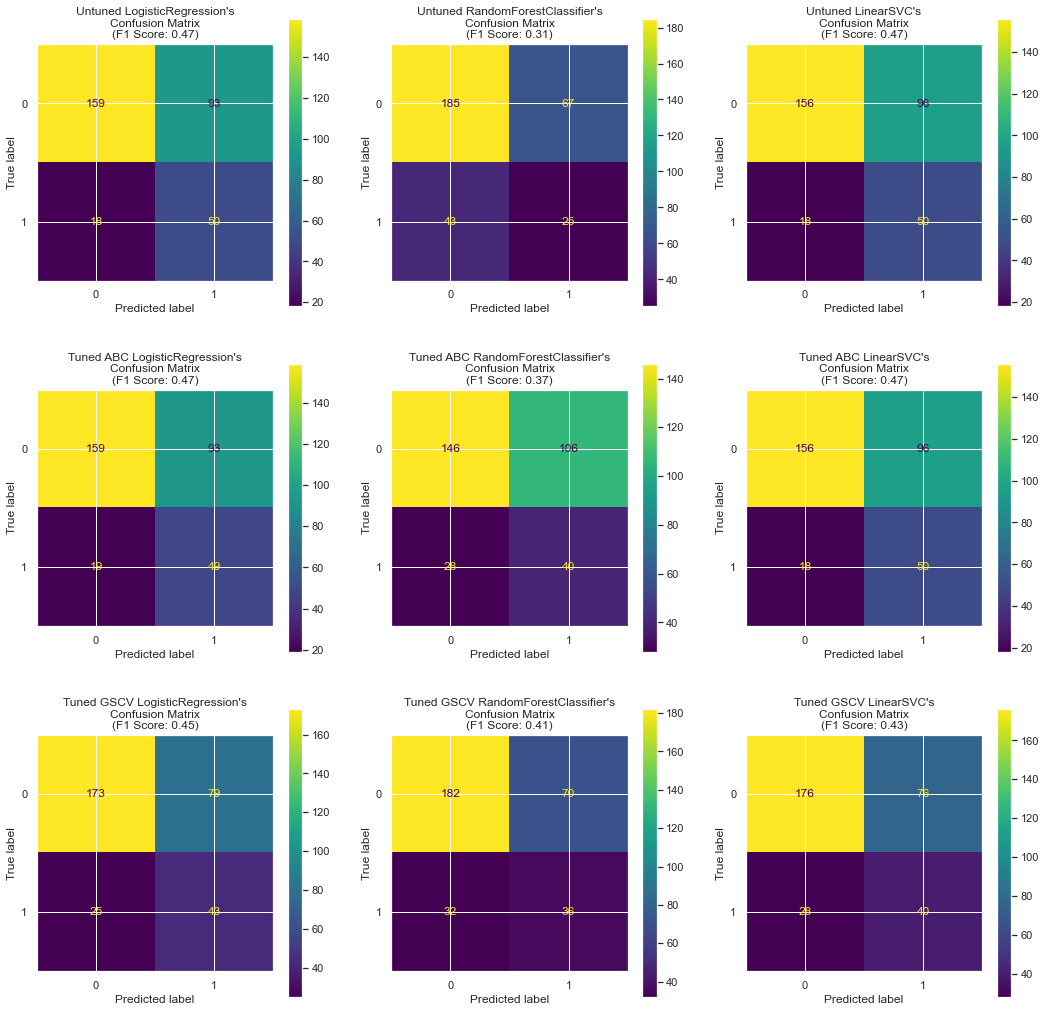

In [451]:
warnings.filterwarnings("ignore")
fig, axes = plt.subplots(3, 3, figsize=(18,18))
# axes = np.flatten(axes)

opt_pb_f1_scorer_with_threshold = make_scorer(optimized_proba_f1_score, 
                                              greater_is_better=True, 
                                              needs_proba=True,
                                              return_threshold=True)

opt_th_f1_scorer_with_threshold = make_scorer(optimized_proba_f1_score, 
                                              greater_is_better=True, 
                                              needs_threshold=True,
                                              return_threshold=True)

for model in models:
    (name, pipeline) = model
    if "Untuned" in name:
        i = 0
    elif "Tuned ABC" in name:
        i = 1
    elif "Tuned GSCV" in name:
        i = 2
        
    if "LogisticRegression" in name:
        j = 0
    if "RandomForestClassifier" in name:
        j = 1
    if "LinearSVC" in name:
        j = 2
    
    if isinstance(pipeline[-1], LinearSVC):
        thresholds = cv_scoring(pipeline, X, y, scoring={"threshold": opt_th_f1_scorer_with_threshold}, cv=StratifiedKFold(n_splits=50, shuffle=True, random_state=42))
        pipeline.fit(X_80, y_80)
        y_pred = pipeline.decision_function(X_test) >= thresholds['test_threshold']
    else:
        thresholds = cv_scoring(pipeline, X, y, scoring={"threshold": opt_pb_f1_scorer_with_threshold}, cv=StratifiedKFold(n_splits=50, shuffle=True, random_state=42))
        pipeline.fit(X_80, y_80)
        y_pred = pipeline.predict_proba(X_test)[:, -1] >= thresholds['test_threshold']
    
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axes[i, j])
    axes[i, j].set_title(f"{name}'s\nConfusion Matrix\n(F1 Score: {f1_score(y_test, y_pred):.2f})")
plt.show()

# Conclusion
LogisticRegression Untuned is the best model according to the optimized F1 score from cross-validation and RandomForestClassifier Tuned with GridSearchCv is the best model according to Average Precision score from cross-validation 

In [470]:
print("LogisticRegression Default Parameters", models[0][-1].steps[-1][-1].get_params())
print("\nRandomForestClassifier Tuned GSCV Parameters", models[-1][-1].steps[-1][-1].get_params())

LogisticRegression Default Parameters {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 23, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

RandomForestClassifier Tuned GSCV Parameters {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 8, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 400, 'n_jobs': -1, 'oob_score': False, 'random_state': 23, 'verbose': 0, 'warm_start': False}
